In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 21 12:06:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   37C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

Тестова задача. Домен [0,2], нульові граничні умови, початкова умова визначається з точного розв'язку [Arora, Geeta, Mishra, Shubham, Emaifar, Homan, Khademi, Masoumeh (2023) Numerical Simulation and Dynamics of Burgers’ Equation Using the Modified Cubic B-Spline Differential Quadrature Method. Discrete Dynamics in Nature and Society Volume 2023, Article ID 5102374, 8 pages
https://doi.org/10.1155/2023/5102374
]:

$\displaystyle u(x,t) =  2 \pi \nu \frac{\sin(\gamma)e^\beta+4\sin(2\gamma)e^{-4\beta}}{4+\cos(\gamma)e^\beta+2\cos(2\gamma)e^{-4\beta}},$

де $\gamma=\pi x$, $\beta=-\pi^2 \nu^2 t$

In [ ]:
# x_max = 1
# t_max = 4

#Розв'язок засобами PINN

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Tanh(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [ ]:
# h = 0.01
# k = 0.01
# nu = 0.5

# x = torch.arange(0,8+h, h)
# t = torch.arange(0,5+k, k)

# X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

# # bc2[:,1]+10e-5
# # X[:,1]
# # bc2.size()
# # X.size()
# y_bc2 = (bc2[:,0]/(bc2[:,1]+10e-6))*1/(1+torch.sqrt((bc2[:,1]+10e-6)*nu/0.125)*torch.exp(bc2[:,0]**2/4*nu*(bc2[:,1]+10e-6)))
# y_bc2

torch.pi

3.141592653589793

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 1.2
        self.t_max = 5

        # comp. domain
        self.h = 0.001
        self.k = 0.01
        self.nu = 0.005
        self.epoch = 2000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)


        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.011042211204767227
0.0008197055431082845
0.010222505778074265
200 0.010740462690591812
0.0008468254818581045
0.009893637150526047
300 0.010213717818260193
0.0007559119840152562
0.009457806125283241
400 0.009072719141840935
0.0005071567720733583
0.008565562777221203
500 0.007291932124644518
0.00022863151389174163
0.0070633008144795895
600 0.004719954915344715
0.0003037506539840251
0.004416204057633877
700 0.0022089157719165087
0.00046925648348405957
0.00173965934664011
800 0.0014751148410141468
0.0005116684478707612
0.0009634463931433856
900 0.0011775591410696507
0.00047436365275643766
0.0007031955174170434
1000 0.0010170885361731052
0.00044126983266323805
0.0005758187035098672
1100 0.0009079336887225509
0.00041341743781231344
0.0004945162800140679
1200 0.0008145138854160905
0.0003833494265563786
0.0004311644588597119
1300 0.0007242323481477797
0.0003498746082186699
0.0003743577399291098
1400 0.0006405621534213424
0.00031747156754136086
0.000323090614983812
1500 0.0005685064243152

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [ ]:
X

tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.2000, 4.9800],
        [1.2000, 4.9900],
        [1.2000, 5.0000]], device='cuda:0')

In [ ]:
X.shape

torch.Size([48521, 2])

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
y_pred.shape

(121, 401)

In [ ]:
y_pred

array([[-0.00012745, -0.00014851, -0.00016478, ..., -0.00023228,
        -0.00023245, -0.00023238],
       [ 0.0097962 ,  0.00967012,  0.00955027, ...,  0.00175637,
         0.00175197,  0.00174764],
       [ 0.01975981,  0.01952879,  0.01930518, ...,  0.00374295,
         0.00373419,  0.00372559],
       ...,
       [ 0.00016043,  0.00016817,  0.00017539, ...,  0.01487346,
         0.01536057,  0.01585723],
       [ 0.00017023,  0.00017807,  0.00018524, ...,  0.01032264,
         0.01071388,  0.0111139 ],
       [ 0.00018027,  0.00018853,  0.00019598, ...,  0.00658891,
         0.00689621,  0.00721089]], dtype=float32)

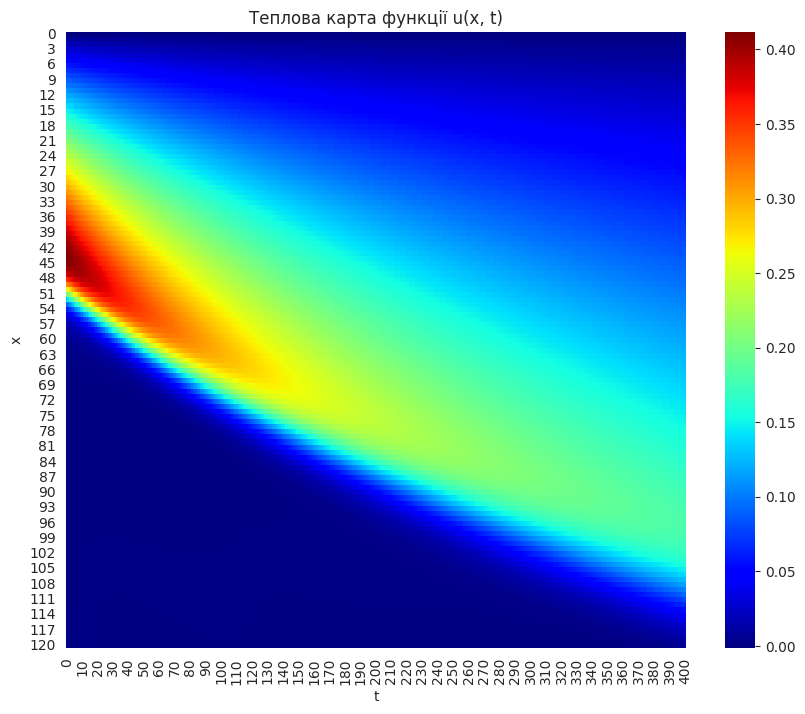

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



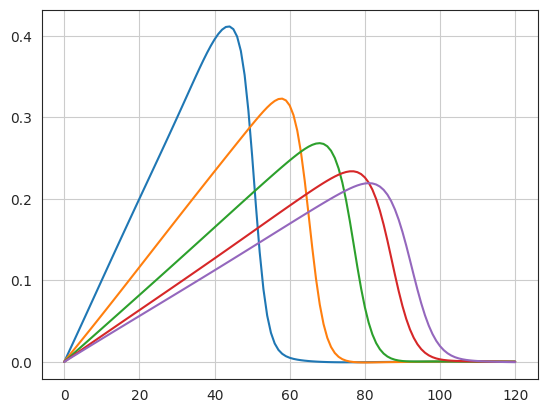

In [ ]:

plt.plot(y_pred[:,0])
plt.plot(y_pred[:,70])
plt.plot(y_pred[:,140])
plt.plot(y_pred[:,210])
plt.plot(y_pred[:,250])

plt.grid(True)
plt.show()

Порівняння з іншими результатами

In [ ]:
def relative_error(exact_values, approx_values):
    # Перевірка на відповідність розмірності списків
    if len(exact_values) != len(approx_values):
        raise ValueError("Списки точних і наближених значень повинні мати однакову довжину.")

    # Ініціалізуємо список для збереження відносних похибок
    relative_errors = []

    # Обчислюємо відносну похибку для кожного спостереження
    for exact, approx in zip(exact_values, approx_values):
        if exact != 0:
            # Обчислення відносної похибки
            error = abs((approx - exact) / exact)
        else:
            # Якщо точне значення дорівнює нулю, встановлюємо похибку як нескінченість
            error = float('inf') if approx != 0 else 0.0

        # Додаємо обчислену відносну похибку до списку
        relative_errors.append(error)

    return relative_errors


In [ ]:
import pandas as pd
data17 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.1176452, 0.2351677, 0.2959097, 0.0006465],
    'PINN': [y_pred[20,70],y_pred[40,70], y_pred[60,70], y_pred[80,70]]
}

df17 = pd.DataFrame(data17)
df17['Relative Error'] = relative_error(df17['Exact'], df17['PINN'])
df17

,x,Exact,PINN,Relative Error
0,0.2,0.117645,0.116082,0.013286
1,0.4,0.235168,0.233670,0.006368
2,0.6,0.295910,0.314480,0.062758
3,0.8,0.000647,-0.000963,2.489966


In [ ]:
import pandas as pd
data25 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.0799990, 0.1599769, 0.2381207, 0.1020957],
    'PINN': [y_pred[20,150],y_pred[40,150], y_pred[60,150], y_pred[80,150]]
}

df25 = pd.DataFrame(data25)
df25['Relative Error'] = relative_error(df25['Exact'], df25['PINN'])
df25

,x,Exact,PINN,Relative Error
0,0.2,0.079999,0.078509,0.018624
1,0.4,0.159977,0.158099,0.011740
2,0.6,0.238121,0.237432,0.002893
3,0.8,0.102096,0.102134,0.000372


In [ ]:
import pandas as pd
data30 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.0666658, 0.1333209, 0.1994805, 0.2088359],
    'PINN': [y_pred[20,200],y_pred[40,200], y_pred[60,200], y_pred[80,200]]
}

df30 = pd.DataFrame(data30)
df30['Relative Error'] = relative_error(df30['Exact'], df30['PINN'])
df30

,x,Exact,PINN,Relative Error
0,0.2,0.066666,0.065405,0.018907
1,0.4,0.133321,0.131108,0.016597
2,0.6,0.199481,0.198026,0.007292
3,0.8,0.208836,0.221796,0.062057


In [ ]:
import pandas as pd
data35 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.0571422, 0.1142779, 0.1712242, 0.2145869],
    'PINN': [y_pred[20,250],y_pred[40,250], y_pred[60,250], y_pred[80,250]]
}

df35 = pd.DataFrame(data35)
df35['Relative Error'] = relative_error(df35['Exact'], df35['PINN'])
df35

,x,Exact,PINN,Relative Error
0,0.2,0.057142,0.056104,0.018171
1,0.4,0.114278,0.112161,0.018521
2,0.6,0.171224,0.169420,0.010535
3,0.8,0.214587,0.218762,0.019455
